In [1]:
##### for logging 
import logging
from logging import debug as lgd
from logging import info as lgi
from logging import error as lge
from io import StringIO
#############
import sys 
import datetime
import a_utils

In [6]:
# logging for debugging 
#
#yfilter=a_utils.LevelFilter((logging.CRITICAL,logging.INFO, logging.WARNING, logging.DEBUG))
yfilter=a_utils.LevelFilter((logging.INFO, logging.CRITICAL))
yfilter1=a_utils.LevelFilter((logging.CRITICAL, logging.CRITICAL))
global lg
lg=a_utils.BTLogger(stream_filter=yfilter, stdout_filter=yfilter1)


In [3]:
# "C:\Users\bt\Documents\GitHub\SigmaCodingBTC\TDAAPI\Automating Stock Investing Technical Analysis With Python _ by Farhad Malik _ FinTechExplained _ Medium_btc.pdf"
# for TA in python https://technical-analysis-library-in-python.readthedocs.io/en/latest/
from ta.momentum import RSIIndicator
from ta.trend import MACD
import numpy as np
import pandas
from ta.volatility import BollingerBands
import talib
import a_utils

class Company:
    def __init__(self, symbol):
        self.symbol = symbol
        self.technical_indicators = None    ### pd dataframe 
        self.prices = None  ### pd series 
        self.img_path=r'C:\Users\bt\Documents\GitHub\SigmaCodingBTC\TDAAPI\historical_data\a_Debug'

    # you don;t need the "y" if this function is declared outside of the Company class
    # this is an instance method, requires "self" as the first arugment in a instance method
    def generate_buy_sell_signals(y, condition_buy, condition_sell, dataframe, strategy):
        last_signal = None
        indicators = []
        buy = []
        sell = [] 

        
        #print(" Buy sell signal() condition_buy type=", type(condition_sell))
        #print(" Buy sell signal() dataframe type=", type(dataframe))
        #print(" Buy sell signal() buy type=", type(buy))
        #print("genbuysellsignal():company.ti ?DF shape", dataframe.shape)

        for i in range(0, len(dataframe)):
            # if buy condition is true and last signal was not Buy
            if condition_buy(i, dataframe) and last_signal != 'Buy':
                last_signal = 'Buy'
                indicators.append(last_signal)
                buy.append(dataframe['Close'].iloc[i])
                sell.append(np.nan)
            # if sell condition is true and last signal was Buy
            elif condition_sell(i, dataframe)  and last_signal == 'Buy':
                last_signal = 'Sell'
                indicators.append(last_signal)
                buy.append(np.nan)
                sell.append(dataframe['Close'].iloc[i])
            else:
                indicators.append(last_signal)
                buy.append(np.nan)
                sell.append(np.nan)

        dataframe[f'{strategy}_Last_Signal'] = np.array(last_signal)
        dataframe[f'{strategy}_Indicator'] = np.array(indicators)
        dataframe[f'{strategy}_Buy'] = np.array(buy)
        dataframe[f'{strategy}_Sell'] = np.array(sell)
        # print("genbuysellsignal():company.ti shape", company.technical_indicators.shape)
        # print("genbuysellsignal():company.ti ?DF shape", dataframe.shape)
def get_sma(config, company):
        close_prices = company.prices
    
        DF2=company.technical_indicators  

        print("get_sma():df2 shape", DF2.shape)
        
        SMAPeriod=10

        ySMA=talib.SMA(close_prices, timeperiod=SMAPeriod)
        DF2['SMA']=ySMA

        print("get_sma():df2 shape", DF2.shape)
        print("get_sma():df2 type", type(DF2))
        print("get_sma():company.ti shape, before gen_signal", company.technical_indicators.shape)
        company.generate_buy_sell_signals(lambda x, dataframe: DF2['SMA'].values[x] < DF2['Close'].iloc[x] , 
                                          lambda x, dataframe: DF2['SMA'].values[x] > DF2['Close'].iloc[x], DF2, 'SMA')
        
        #print("genbuysellsignal():company.ti shape after gen_signal", company.technical_indicators.shape)
        return DF2         

def set_technical_indicators(config, company):
        company.technical_indicators = pandas.DataFrame()
        company.technical_indicators['Close'] = company.prices  # tech_indicator is now fully stacked with on column , with index

        #print ("new", company.technical_indicators)
        
        get_sma(config, company)
        #print ("after SMA",company.technical_indicators)

        #print ("before MACD",yGoog.technical_indicators)
        get_macd(config, company)
        
        #print ("before RSI",yGoog.technical_indicators)
        get_rsi(config, company)
        
        #print ("After RSI", company.technical_indicators)
        get_bollinger_bands(config, company)

def get_macd(config, company):
        close_prices = company.prices
        dataframe1 = company.technical_indicators
        window_slow = 26
        signal = 9
        window_fast = 12
        macd = MACD(company.prices, window_slow, window_fast, signal)
        dataframe1['MACD'] = macd.macd()
        dataframe1['MACD_Histogram'] = macd.macd_diff()
        dataframe1['MACD_Signal'] = macd.macd_signal()

        #print("df len", len(dataframe1))
    
        company.generate_buy_sell_signals(lambda x, dataframe: dataframe['MACD'].values[x] < dataframe['MACD_Signal'].iloc[x] , 
                                        lambda x, dataframe: dataframe['MACD'].values[x] > dataframe['MACD_Signal'].iloc[x], 
                                        dataframe1, 'MACD')
                                        
        return dataframe1

def get_rsi(config, company):
    close_prices = company.prices
    dataframe = company.technical_indicators
    rsi_time_period = 20
    rsi_indicator = RSIIndicator(close_prices, rsi_time_period)
    dataframe['RSI'] = rsi_indicator.rsi()
    low_rsi = 40
    high_rsi = 70
    company.generate_buy_sell_signals(
        lambda x, dataframe: dataframe['RSI'].values[x] < low_rsi,
        lambda x, dataframe: dataframe['RSI'].values[x] > high_rsi, dataframe, 'RSI')
    return dataframe


def get_bollinger_bands(config, company):
    close_prices = company.prices
    dataframe = company.technical_indicators
    window = 20
    indicator_bb = BollingerBands(close=close_prices, window=window,window_dev=2)
    # Add Bollinger Bands features
    dataframe['Bollinger_Bands_Middle'] =indicator_bb.bollinger_mavg()
    dataframe['Bollinger_Bands_Upper'] =indicator_bb.bollinger_hband()
    dataframe['Bollinger_Bands_Lower'] =indicator_bb.bollinger_lband()
    company.generate_buy_sell_signals(
        lambda x, signal: signal['Close'].values[x] < signal['Bollinger_Bands_Lower'].values[x], 
        lambda x, signal: signal['Close'].values[x] >
        signal['Bollinger_Bands_Upper'].values[x],
        dataframe, 'Bollinger_Bands')
    return dataframe

In [7]:
# plotting 
# from "C:\Users\bt\Documents\GitHub\SigmaCodingBTC\TDAAPI\Automating Stock Investing Technical Analysis With Python _ by Farhad Malik _ FinTechExplained _ Medium_btc.pdf"
# started wit matplotlib tutorial:
# https://matplotlib.org/stable/tutorials/index.html


import os
from matplotlib import pyplot as plt
import numpy as np
class TechnicalIndicatorsChartPlotter:
    def plot_price_and_signals(self, fig, company, data, strategy,axs):
            last_signal_val = data[f'{strategy}_Last_Signal'].values[-1]
            last_signal = 'Unknown' if not last_signal_val else last_signal_val
        
            title = f'Close Price Buy/Sell Signals using {strategy}.Last Signal: {last_signal}'
            fig.suptitle(f'Top: {company.symbol} Stock Price. Bottom:{strategy}')

            if not data[f'{strategy}_Buy'].isnull().all():
                axs[0].scatter(data.index, data[f'{strategy}_Buy'], color='green', label='Buy Signal', marker='^', alpha=1)

            if not data[f'{strategy}_Sell'].isnull().all():
                axs[0].scatter(data.index, data[f'{strategy}_Sell'], color='red', label='Sell Signal', marker='v', alpha=1)
                axs[0].plot(company.prices, label='Close Price',color='blue', alpha=0.35)

            plt.xticks(rotation=45)
            axs[0].set_title(title)
            axs[0].set_xlabel('Date', fontsize=18)
            axs[0].set_ylabel('Close Price', fontsize=18)
            axs[0].legend(loc='upper left')
            axs[0].grid()

    def plot_macd(self, company):
            image = f'images/{company.symbol}_macd.png'
            macd = company.technical_indicators
            # Create and plot the graph
            fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
            self.plot_price_and_signals(fig, company, macd, 'MACD', axs)
            axs[1].plot(macd['MACD'], label=company.symbol+' MACD', color= 'green')
            axs[1].plot(macd['MACD_Signal'], label='Signal Line',color='orange')
            positive = macd['MACD_Histogram'][(macd['MACD_Histogram'] >=0)]
            negative = macd['MACD_Histogram'][(macd['MACD_Histogram'] <0)]
            axs[1].bar(positive.index, positive, color='green')
            axs[1].bar(negative.index, negative, color='red')
            axs[1].legend(loc='upper left')
            axs[1].grid()
            #print(os.path.abspath(image))
            
            self.save_plot(company,'macd', plt)
            plt.show()

    def plot_rsi(self, company):
            image = f'images/{company.symbol}_rsi.png'
            rsi = company.technical_indicators
            low_rsi = 40
            high_rsi = 70
        #plt.style.use('default')
            fig, axs = plt.subplots(2, sharex=True, figsize=(13, 9))
            self.plot_price_and_signals(fig, company, rsi, 'RSI', axs)
            axs[1].fill_between(rsi.index, y1=low_rsi, y2=high_rsi, color='#adccff', alpha=0.3)
            axs[1].plot(rsi['RSI'], label='RSI', color='blue',alpha=0.35)
            axs[1].legend(loc='upper left')
            axs[1].grid()
           
            self.save_plot(company,'rsi', plt)  
            plt.show()

    def plot_bollinger_bands(self, company):
            image = f'images/{company.symbol}_bb.png'
            bollinger_bands = company.technical_indicators

            
            fig, axs = plt.subplots(2, sharex=True, figsize=(13, 9))

            self.plot_price_and_signals(fig, company, bollinger_bands, 'Bollinger_Bands', axs)

            axs[1].plot(bollinger_bands['Bollinger_Bands_Middle'], label='Middle', color='blue', alpha=0.35)
            axs[1].plot(bollinger_bands['Bollinger_Bands_Upper'], label='Upper', color='green', alpha=0.35)
            axs[1].plot(bollinger_bands['Bollinger_Bands_Lower'], label='Lower', color='red', alpha=0.35)
            axs[1].fill_between(bollinger_bands.index, bollinger_bands['Bollinger_Bands_Lower'], bollinger_bands['Bollinger_Bands_Upper'], alpha=0.1)
            axs[1].legend(loc='upper left')

            axs[1].grid()
            
            self.save_plot(company,'BB', plt)  
            plt.show()
            
    def plot_sma(self, company):
            
            sma = company.technical_indicators
            # Create and plot the graph
            fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
            ##### self.plot_price_and_signals(fig, company, sma, 'SMA', axs)
            axs[1].plot(sma['SMA'],  label=company.symbol+' SMA', color= 'green')
            axs[1].plot(sma['Close'], label='Signal Line',color='orange')
            
    
            axs[1].legend(loc='upper left')
            axs[1].grid()
           
                 
            # save image before the show
            self.save_plot(company, 'SMA', plt )
            plt.show()



    def save_plot(self, company, strategy, plot):
            filenm = f'{company.symbol}_{strategy}'    
            yPath= a_utils.addDir(company.img_path, company.symbol)
            yPath= a_utils.FilePath(Path=yPath, FileNm=filenm, TimeString='', Suffix='')
            plot.savefig(yPath) 






get_sma():df2 shape (72, 1)
get_sma():df2 shape (72, 2)
get_sma():df2 type <class 'pandas.core.frame.DataFrame'>
get_sma():company.ti shape, before gen_signal (72, 2)


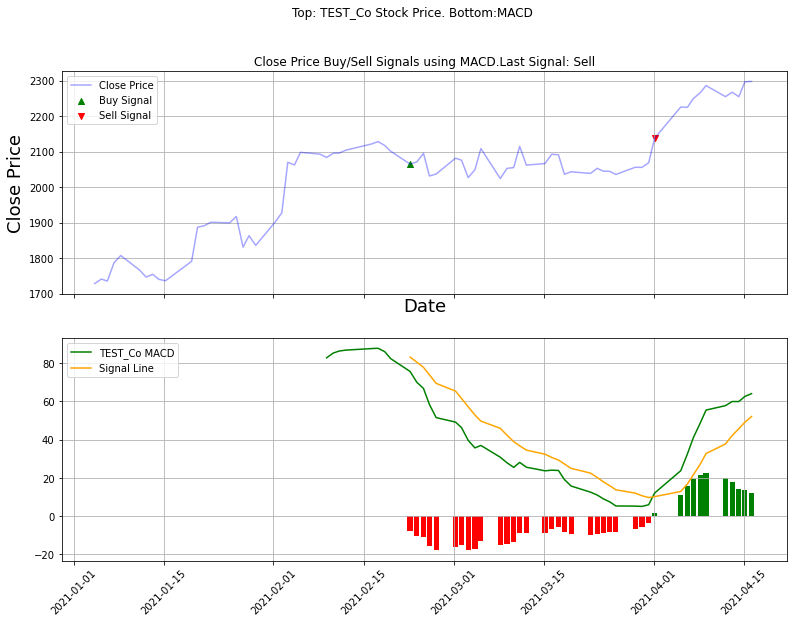

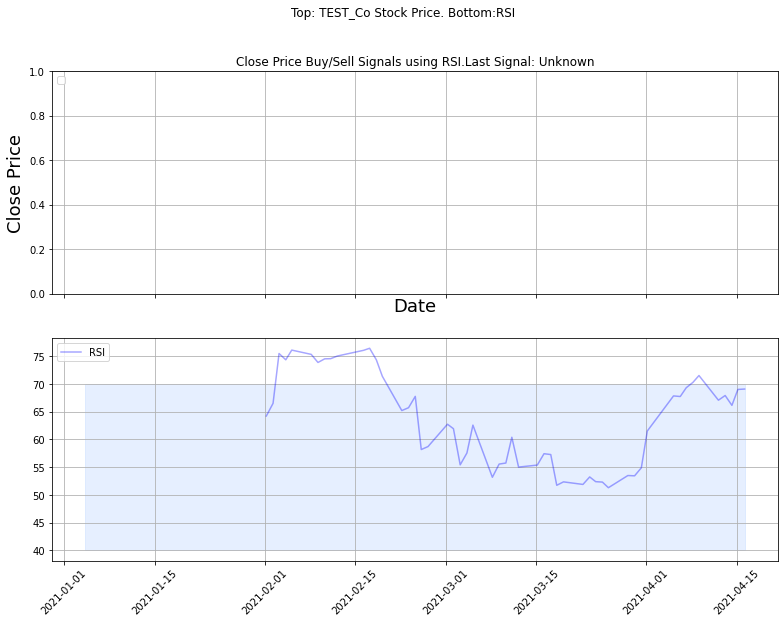

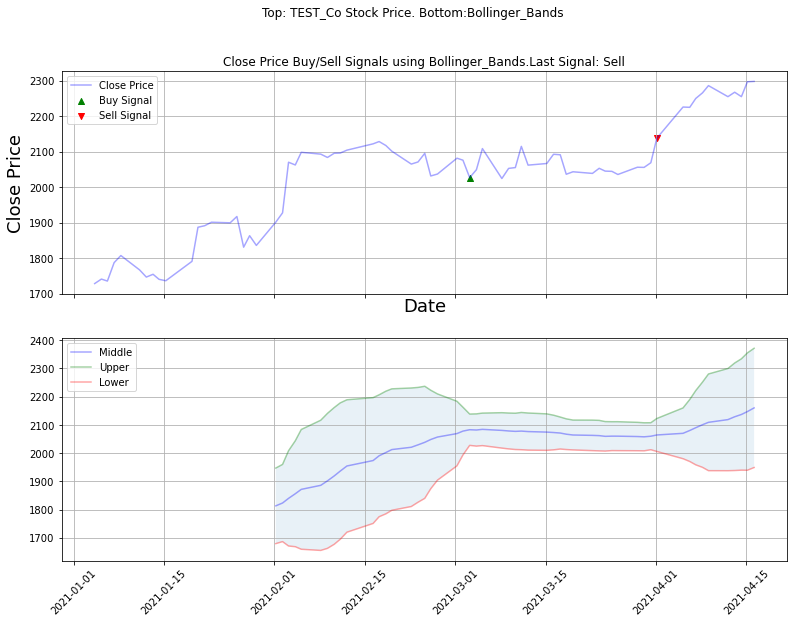

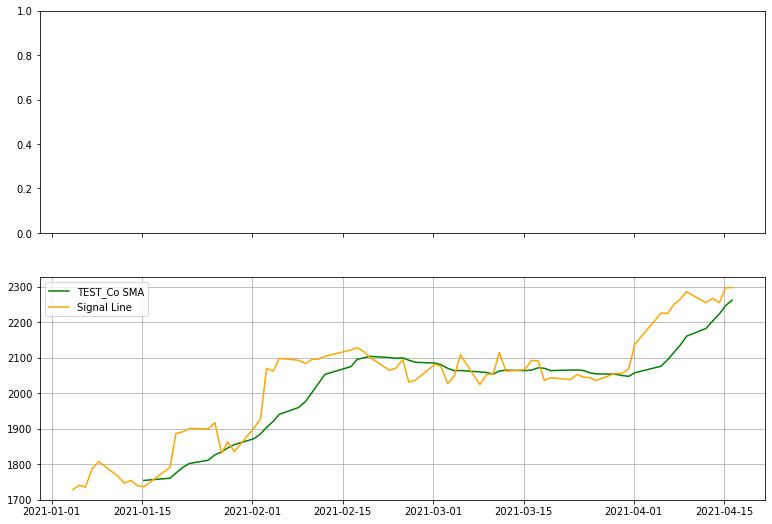

In [8]:
# test code

from unittest import TestCase
import yfinance as yf
import pandas as pd
#wait:from yTA_Cal import set_technical_indicators, Company
#wait:from yTA_Plot import TA_chart_plotter


## for a TA function 
## tadf=add_all_ta_features(df1, open='open', high='high', low='low', close='close', volume='volume', fillna=True) 
config={}
yGoog=Company('GOOG')
yGoog.prices=  yf.Ticker(yGoog.symbol).history(period='1y')['Close']

#print('----------GooG')
#print(yGoog.prices)
#yGoog.prices=yDSTDA  #w yf.Ticker(yGoog.symbol).history(period='1y')['Close']


yTestCo=Company('TEST_Co')
###############################################################
DF2=pd.read_csv(r'C:\Users\bt\Documents\GitHub\SigmaCodingBTC\TDAAPI\historical_data\a_Debug\GOOG_TDA_raw.csv')
DF2['Date']= pd.to_datetime(DF2['datetime'], unit='ms')  # datetime is timestamp /Epoch, Date is py datetime obj  
#DF2.rename(columns={'close':'Close'})
yTestCo.prices= pd.Series(DF2['close'].values, index=DF2['Date']) #price is PD series, with datetimeindex obj 

# yTestCo.name='Close'   #give PD series a name, not to any effect

###############################################################


#select between two different sources 
# from yahoo with pd ds with column "Close" and datetime item as index 
#yTestCo=yGoog

set_technical_indicators(config, yTestCo)

#print(yTestCo.technical_indicators)
#print (yGoog.technical_indicators)

tacp=TechnicalIndicatorsChartPlotter() 
tacp.plot_macd(yTestCo)
tacp.plot_rsi(yTestCo)
tacp.plot_bollinger_bands(yTestCo)
tacp.plot_sma(yTestCo) 

#print('----------- TestCo')
#print("testco.prices type=", type(yTestCo.prices))
#print("testco.prices index type", type(yTestCo.prices.index))
#print("testco.prices index type", yTestCo.prices.dtypes)


#print('--------------')
#print ('DF2 type=', type(DF2))
#print("index type", type(DF2.index))
# print (' testo.tech ind =', DF2)


#print('--------------')
#print ('testco technical indicator type=', type(yTestCo.technical_indicators))
#print("testco.tech ind index type", type(yTestCo.technical_indicators.index))
#print (' testo.tech ind =', yTestCo.technical_indicators)